In [108]:
import numpy as np
from math import sqrt
import skimage.io as io
import lmfit
from lmfit.lineshapes import gaussian2d, lorentzian
from skimage import transform
from skimage.feature import blob_log, blob_doh, blob_dog
from scipy import ndimage
from skimage.measure import ransac
import pandas as pd
from sklearn.linear_model import RANSACRegressor
import pandas as pd
from scipy import spatial
import scipy.misc as sp
from skimage.filters import gaussian
from PIL import Image
from sklearn.metrics import mean_squared_error
from cmath import inf

import matplotlib.pyplot as plt
from matplotlib import axes
from matplotlib import figure

plt.rcParams["figure.dpi"] = 300


In [308]:
def residual_cal(src, dst):
    mse = mean_squared_error(src, dst)
    return mse


def blob_detection(img_path, min_sigma, max_sigma, threshold, method=0):
    img = io.imread(img_path)
    if method == 0:
        blob = blob_dog(
            img, min_sigma=min_sigma, max_sigma=max_sigma, threshold=threshold
        )
    else:
        blob = blob_doh(
            img, min_sigma=min_sigma, max_sigma=max_sigma, threshold=threshold
        )
    i = 0
    # r = 3
    centers = []
    h, w = img.shape
    for blob in blob:
        y, x, r = blob
        if y > r and y < (h - r) and x > r and x < (w - r):
            centers.append(
                ndimage.measurements.center_of_mass(
                    img[int(y - r) : int(y + r + 1), int(x - r) : int(x + r + 1)]
                )
            )
            centers[i] = list(np.add(centers[i], [x - r, y - r]))
            i += 1
    return np.array(centers)


class QuadPolyTrans(transform.PolynomialTransform):
    def estimate(*data):
        return transform.PolynomialTransform.estimate(*data, order=2)


class CubicPolyTrans(transform.PolynomialTransform):
    def estimate(*data):
        return transform.PolynomialTransform.estimate(*data, order=3)


def count_nearest_pts(src, dst, radius):
    tree = spatial.KDTree(src)
    res, idx = tree.query(dst, k=1, distance_upper_bound=radius)
    for i in range(0, len(idx)):
        if len(np.argwhere(idx == idx[i])) > 1:
            res[i] = inf
    return res, idx


def save_np_img(npimg, path):
    img = Image.fromarray(npimg)
    img = img.convert("L")
    img.save(path, dpi=(300.0, 300.0))


def ploting_res(canvas_size, res, pts_radius, save_path, gaussian_sigma=3):
    x_range, y_range = canvas_size
    pk_img = np.zeros(canvas_size)
    for ele in res:
        y = int(ele[0])
        x = int(ele[1])
        for j in range(0, pts_radius):
            for k in range(0, pts_radius):
                pk_img[
                    min(max(0, x - j), x_range - 1), min(max(0, y - k), y_range - 1)
                ] = (1024 * 2)
                pk_img[
                    min(x_range - 1, max(0, x + j)), min(max(0, y - k), y_range - 1)
                ] = (1024 * 2)
                pk_img[
                    min(x_range - 1, max(0, x + j)), min(y_range - 1, max(0, y + k))
                ] = (1024 * 2)
                pk_img[
                    min(max(0, x - j), x_range - 1), min(y_range - 1, max(0, y + k))
                ] = (1024 * 2)
    blurred_img = gaussian(pk_img, sigma=gaussian_sigma, multichannel=False)
    save_np_img(blurred_img, save_path)


def count_pairs(ref_coord, target_coord, radius):
    tree = spatial.KDTree(ref_coord)
    res, idx = tree.query(target_coord, k=1)
    polished_fretPts = ref_coord[idx[np.where(res != inf)]]
    pairs = 0
    pp = 0
    for i in idx:
        if res[pp] < radius:
            pairs += 1
        pp += 1
    return pairs


def read_coord(csv_path):
    res_tb = pd.read_csv(csv_path)
    pts = np.column_stack(
        (np.array(res_tb["X"][0 : len(res_tb)]), np.array(res_tb["Y"][0 : len(res_tb)]))
    )
    return pts


def show_blob_detection_res(img_path, min_sigma, max_sigma, threshold, method=0):
    fig, ax = plt.subplots()
    img = io.imread(img_path)
    ax.imshow(img)
    if method == 0:
        res = blob_dog(
            img,
            min_sigma=min_sigma,
            max_sigma=max_sigma,
            threshold=threshold,
        )
    else:
        res = blob_doh(
            img,
            min_sigma=min_sigma,
            max_sigma=max_sigma,
            threshold=threshold,
        )
    i = 0
    CM = []
    r = 3
    [h, w] = img.shape
    for blob in res:
        y, x, r = blob
        # print(r)
        if y > r and y < (h - r) and x > r and x < (w - r):
            CM.append(
                ndimage.measurements.center_of_mass(
                    img[int(y - r) : int(y + r), int(x - r) : int(x + r)]
                )
            )
            CM[i] = list(np.add(CM[i], [y - r, x - r]))
            x1, y1 = CM[i]
            c = plt.Circle([y1, x1], 3, color="red", linewidth=1, fill=False)
            ax.add_patch(c)
            i += 1
    ax.set_axis_off()
    plt.show()


- Using mannually labelled beads as the first rough alignment
- Getting centers of automatically labelled beads (using center of mass)

In [269]:
res_tb = pd.read_csv(
    "/Users/qinhanhou/Desktop/DeindlLab/Git/MUSCLE/ExampleData/Test/Results.csv"
)
sample_num = int(len(res_tb) / 2)
src = np.column_stack(
    (np.array(res_tb["XM"][0:sample_num]), np.array(res_tb["YM"][0:sample_num]))
)
dst = np.column_stack(
    (np.array(res_tb["XM"][sample_num:]), np.array(res_tb["YM"][sample_num:]))
)

# print(src)
# print(dst)

rough_tf = transform.estimate_transform("affine", src=src, dst=dst)
# print(rough_tf(src))

movie_centers = blob_detection(
    "/Users/qinhanhou/Desktop/DeindlLab/Git/MUSCLE/ExampleData/Pos246/beads_246_fret_channel.tif",
    min_sigma=1,
    max_sigma=10,
    threshold=0.01,
)

seq_centers = blob_detection(
    "/Users/qinhanhou/Desktop/DeindlLab/Git/MUSCLE/ExampleData/Pos246/min_projection_246.tif",
    min_sigma=20,
    max_sigma=500,
    threshold=0.001,
    method=1,
)

# show_blob_detection_res(
#     "/Users/qinhanhou/Desktop/DeindlLab/Git/MUSCLE/ExampleData/Pos246/beads_246_fret_channel.tif",
#     min_sigma=1,
#     max_sigma=10,
#     threshold=0.01,
# )
# show_blob_detection_res(
#     "/Users/qinhanhou/Desktop/DeindlLab/Git/MUSCLE/ExampleData/Pos246/min_projection_246.tif",
#     min_sigma=20,
#     max_sigma=500,
#     threshold=0.001,
#     method=1,
# )


TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


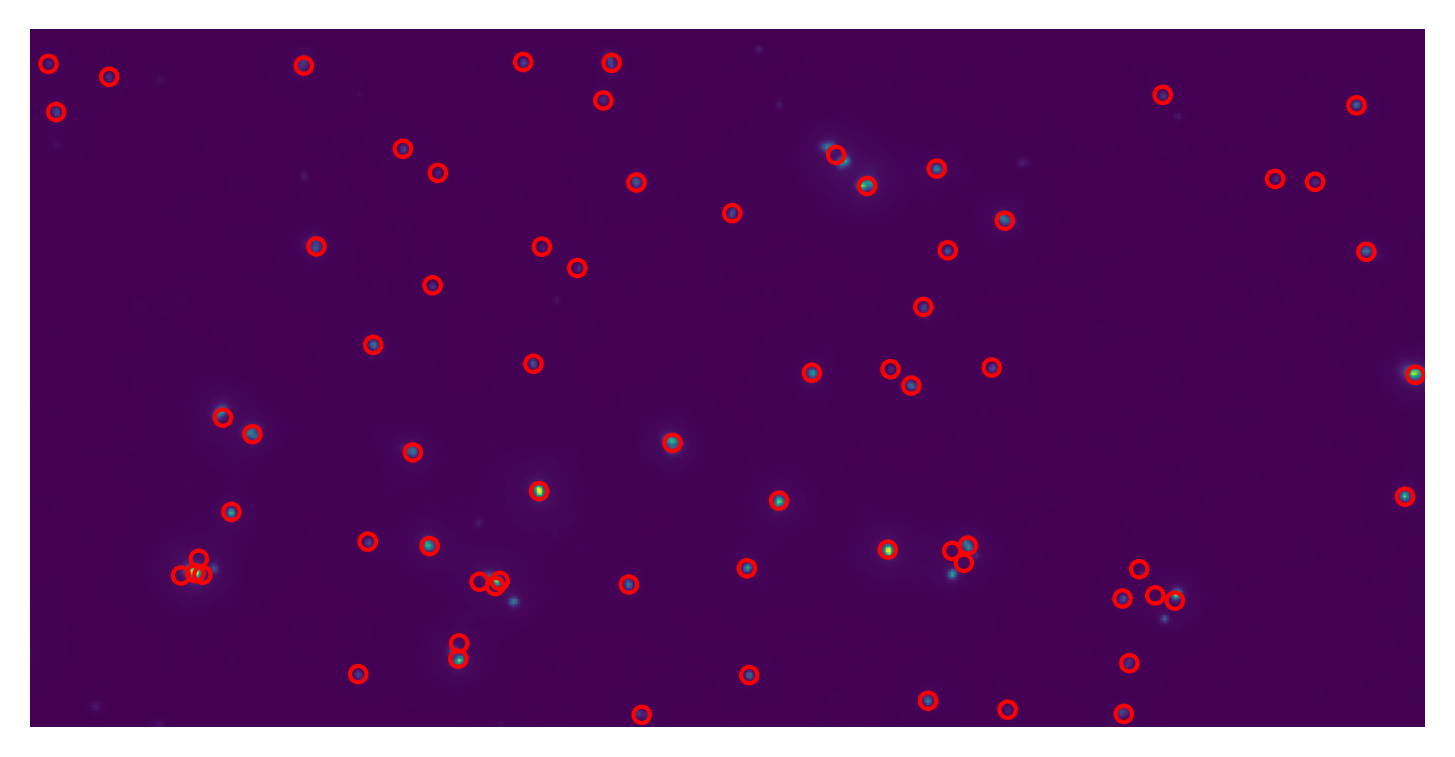

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


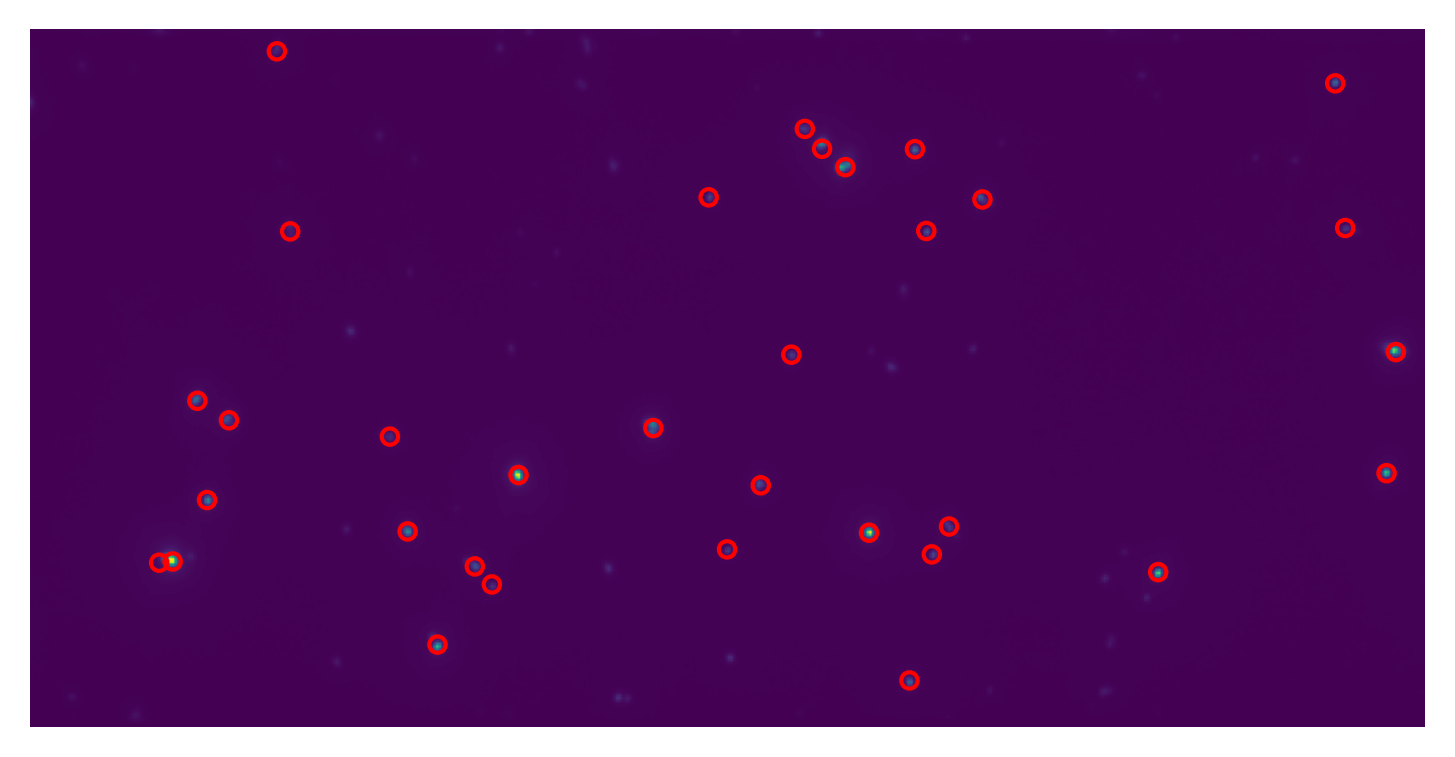

[[415.05220381 198.99843701]
 [ 60.01935179 134.04546885]
 [164.0893684  195.04537877]
 [316.40385859 123.97529932]
 [396.00186027 242.02852418]
 [319.92256565  94.95484136]
 [389.91068016 246.94510961]
 [438.43397322  87.47175315]
 [197.99821429 248.92293719]
 [186.90573394 247.90049148]
 [ 79.94434147 247.97121287]
 [484.98915569 232.00580945]
 [116.88390411 249.92140411]
 [ 53.93307234  36.97471887]
 [ 44.03453012 187.03904257]
 [140.94421998 216.95903479]
 [324.97905759 196.9786745 ]
 [384.49266612  89.40655487]
 [412.92241174  71.93649345]
 [339.00961538 107.98726611]
 [246.91165536 207.90442608]
 [336.98655745 239.94286915]
 [331.99524025 135.96600181]]
[[414.29681556 198.96565251]
 [ 60.47869238 135.60814714]
 [163.37264794 195.97139973]
 [315.89340905 123.98382864]
 [394.34556298 242.10790548]
 [320.08035511  95.25192746]
 [388.93598955 248.0914435 ]
 [436.97883218  86.95506095]
 [198.9213138  248.97013759]
 [186.34715428 246.41528103]
 [ 79.92017107 248.94748445]
 [484.3884256

In [155]:
green_channel_centers = blob_detection(
    "/Users/qinhanhou/Desktop/DeindlLab/0729Poly/0822_Combine2Channel/grenn_channel_beads.tif",
    min_sigma=1,
    max_sigma=8,
    threshold=0.0001,
)

red_channel_centers = blob_detection(
    "/Users/qinhanhou/Desktop/DeindlLab/0729Poly/0822_Combine2Channel/red_channel_beads.tif",
    min_sigma=1,
    max_sigma=8,
    threshold=0.0001,
)

# show_blob_detection_res('/Users/qinhanhou/Desktop/DeindlLab/0729Poly/0822_Combine2Channel/grenn_channel_beads.tif')
# show_blob_detection_res('/Users/qinhanhou/Desktop/DeindlLab/0729Poly/0822_Combine2Channel/red_channel_beads.tif')

res, idx = count_nearest_pts(green_channel_centers, red_channel_centers, 2)
# print(idx)
# print(res)

usable_green_beads = green_channel_centers[idx[np.where(res != inf)]]
usable_red_beads = red_channel_centers[np.where(res != inf)]
print(usable_green_beads)
print(usable_red_beads)

tform = transform.AffineTransform()
tform.estimate(usable_green_beads, usable_red_beads)
tsformed_green_beads = tform(usable_green_beads)
print(tsformed_green_beads)
ploting_res(
    (256, 512),
    res=usable_red_beads,
    pts_radius=2,
    save_path="/Users/qinhanhou/Desktop/DeindlLab/0729Poly/0822_Combine2Channel/red_beads.png",
)
ploting_res(
    (256, 512),
    res=tsformed_green_beads,
    pts_radius=2,
    save_path="/Users/qinhanhou/Desktop/DeindlLab/0729Poly/0822_Combine2Channel/tform_green_beads.png",
)


In [288]:
green_channel_peaks = read_coord(
    "/Users/qinhanhou/Desktop/DeindlLab/0729Poly/0822_Combine2Channel/Green_channel_peaks.csv"
)
red_channel_peaks = read_coord(
    "/Users/qinhanhou/Desktop/DeindlLab/0729Poly/0822_Combine2Channel/Red_channel_peaks.csv"
)
print(tform(green_channel_peaks))
combiened_peaks = np.concatenate((tform(green_channel_peaks), red_channel_peaks))
print(combiened_peaks)


[[210.21278048  58.47433851]
 [255.51485428 235.92485222]
 [364.7369936   42.24271431]
 ...
 [ 17.33887663 231.36005557]
 [ 15.31518074 241.33728092]
 [ 16.28437907 250.31183921]]
[[210.21278048  58.47433851]
 [255.51485428 235.92485222]
 [364.7369936   42.24271431]
 ...
 [  2.         231.        ]
 [ 11.         230.        ]
 [ 23.          15.        ]]


## Plotting simple linear transformed beads and beads from seq image
Then we will use them to do the RANSAC test and get the reliable pairs

In [263]:
x_range = 1566
y_range = 3240
print(rough_tf(movie_centers))
print(seq_centers)
ploting_res(
    (x_range, y_range),
    res=rough_tf(movie_centers),
    pts_radius=3,
    save_path="/Users/qinhanhou/Desktop/DeindlLab/0729Poly/0822_Combine2Channel/movie_center.png",
)
ploting_res(
    (x_range, y_range),
    res=seq_centers,
    pts_radius=3,
    save_path="/Users/qinhanhou/Desktop/DeindlLab/0729Poly/0822_Combine2Channel/seq_center.png",
)


[[ 528.21532662  296.01929469]
 [1128.96697482 1414.47818913]
 [ 376.33461521 1487.97401176]
 [ 599.68286765  953.54140139]
 [1770.51475813 1124.38093029]
 [ 465.50709797 1407.04350498]
 [1068.3505937   192.93844911]
 [ 433.4946576  1281.39471712]
 [2788.9207256   629.43649169]
 [ 742.84674574 1209.89570064]]
[[ 529.40063777  293.38320347]
 [1127.09283872 1418.31100455]
 [ 373.49989326 1488.00769231]
 [ 602.91430711  955.02699728]
 [1772.29126133 1122.59562357]
 [ 461.11704043 1404.67451301]
 [1068.72480839  191.18548077]
 [ 428.95868046 1274.7789768 ]
 [2796.16454426  624.59353588]
 [ 742.35971361 1207.66240491]]


In [272]:
res, idx = count_nearest_pts(rough_tf(movie_centers), seq_centers, 8)
print(res)
print(idx)
movie_centers = movie_centers[idx[np.where(res != inf)]]
seq_centers = seq_centers[np.where(res != inf)]

print(movie_centers)
print(seq_centers)

model, inliers = ransac(
    (movie_centers, seq_centers),
    QuadPolyTrans,
    4,
    5,
    initial_inliers=np.ones(len(movie_centers), dtype=bool),
    stop_probability=0.8,
)
print(inliers)
print(model(movie_centers))
print(seq_centers)
print(residual_cal(model(movie_centers), seq_centers))

ploting_res(
    (x_range, y_range),
    model(movie_centers),
    3,
    "/Users/qinhanhou/Desktop/DeindlLab/0729Poly/0822_Combine2Channel/movie_center_f.png",
)
ploting_res(
    (x_range, y_range),
    seq_centers,
    3,
    "/Users/qinhanhou/Desktop/DeindlLab/0729Poly/0822_Combine2Channel/seq_center_f.png",
)


[2.89031822 4.26648101 2.83492203 3.55657084 2.51858764 4.9884595
 1.79246608 2.28578435]
[0 1 2 3 4 5 6 7]
[[ 60.71286237  26.60201787]
 [159.50942063 213.31693191]
 [ 33.21884831 225.97614063]
 [ 71.57109354 136.50704513]
 [267.54829127 164.49581076]
 [ 48.30509793 212.400363  ]
 [151.43263736   9.10066641]
 [ 95.1324732  179.29999911]]
[[ 529.40063777  293.38320347]
 [1127.09283872 1418.31100455]
 [ 373.49989326 1488.00769231]
 [ 602.91430711  955.02699728]
 [1772.29126133 1122.59562357]
 [ 461.11704043 1404.67451301]
 [1068.72480839  191.18548077]
 [ 742.35971361 1207.66240491]]
[ True  True  True  True  True  True  True  True]
[[ 529.80015362  294.09499409]
 [1126.63953489 1417.05501715]
 [ 372.29482356 1486.69105912]
 [ 601.9458689   952.54650183]
 [1772.42606602 1122.88532393]
 [ 462.8414078  1406.34248546]
 [1068.61453902  190.93954426]
 [ 742.93504897 1210.36976882]]
[[ 529.40063777  293.38320347]
 [1127.09283872 1418.31100455]
 [ 373.49989326 1488.00769231]
 [ 602.91430711  9

In [310]:
# peaks_tb = pd.read_csv("/Users/qinhanhou/Desktop/DeindlLab/0729Poly/0817/peaks.csv")
# sample_num_peaks = int(len(peaks_tb))
# peak_locations = np.column_stack(
#     (
#         np.array(peaks_tb["X"][0:sample_num_peaks]),
#         np.array(peaks_tb["Y"][0:sample_num_peaks]),
#     )
# )
peak_locations = combiened_peaks

res = model(np.array(peak_locations))

save_path = "/Users/qinhanhou/Desktop/DeindlLab/0729Poly/0822_Combine2Channel/"
canvas_size = (1566, 3240)
ploting_res(canvas_size, res, 3, save_path + "transformed_res.png")
fastq = read_coord("/Users/qinhanhou/Desktop/DeindlLab/0729Poly/0817/coord_lib.csv")
res_1, idx_1 = count_nearest_pts(res, fastq, 20)
polished_movie = res[idx_1[np.where(res_1 != inf)]]
polished_fastq = fastq[np.where(res_1 != inf)]
print(len(polished_fastq))
ploting_res((x_range, y_range), polished_fastq, 10, save_path=save_path + "fastq.png", gaussian_sigma=10)
ploting_res((x_range, y_range), polished_movie, 3, save_path=save_path + "fret.png")


324


In [295]:
max_iter = 3
polished_fretPts_k = polished_movie
polished_fastq_k = polished_fastq
print(len(polished_fretPts_k))
print(len(polished_fastq_k))
fastq = read_coord("/Users/qinhanhou/Desktop/DeindlLab/0729Poly/0817/coord_lib.csv")

for i in range(0, max_iter):
    refined_model, inliers = ransac(
        (polished_fretPts_k, polished_fastq_k),
        QuadPolyTrans,
        int(len(polished_fretPts_k) * 0.6),
        # 10,
        8,
        initial_inliers=np.ones(len(polished_fretPts_k), dtype=bool),
        stop_probability=1,
        max_trials=1000,
    )
    print(inliers)
    res = refined_model(res)
    res_2, idx_2 = count_nearest_pts(res, fastq, 5)
    polished_fretPts_k = res[idx_2[np.where(res_2 != inf)]]
    polished_fastq_k = fastq[np.where(res_2 != inf)]
    print(len(polished_fastq_k))
    # print(polished_fastq_k)
    # print(fastq)
    ploting_res(
        (x_range, y_range),
        polished_fastq_k,
        3,
        save_path + "polished_fastq_15_iter" + str(i) + ".png",
    )
    ploting_res(
        (x_range, y_range),
        polished_fretPts_k,
        3,
        save_path + "polished_fretPts_15_iter" + str(i) + ".png",
    )
    ploting_res(
        (x_range, y_range), res, 3, save_path + "fretPts_iter" + str(i) + ".png"
    )
    ploting_res(
        (x_range, y_range), fastq, 3, save_path + "refined_fastq_iter" + str(i) + ".png"
    )
res_final, idx_final = count_nearest_pts(res, fastq, 10)
polished_fretPts_final = res[idx_final[np.where(res_final != inf)]]
polished_fastq_final = fastq[np.where(res_final != inf)]
print(len(polished_fastq_final))
ploting_res(
    (x_range, y_range),
    polished_fastq_final,
    3,
    save_path + "final_polished_fastq.png",
)
ploting_res(
    (x_range, y_range),
    polished_fretPts_final,
    3,
    save_path + "final_polished_fretPts.png",
)


13
13
[ True  True  True  True  True  True  True  True  True  True  True  True
  True]
29
[ True  True  True False  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True False  True]
27
[ True  True  True  True  True  True False  True  True False  True  True
  True False  True  True  True  True  True  True  True False  True  True
  True False False]
30
111


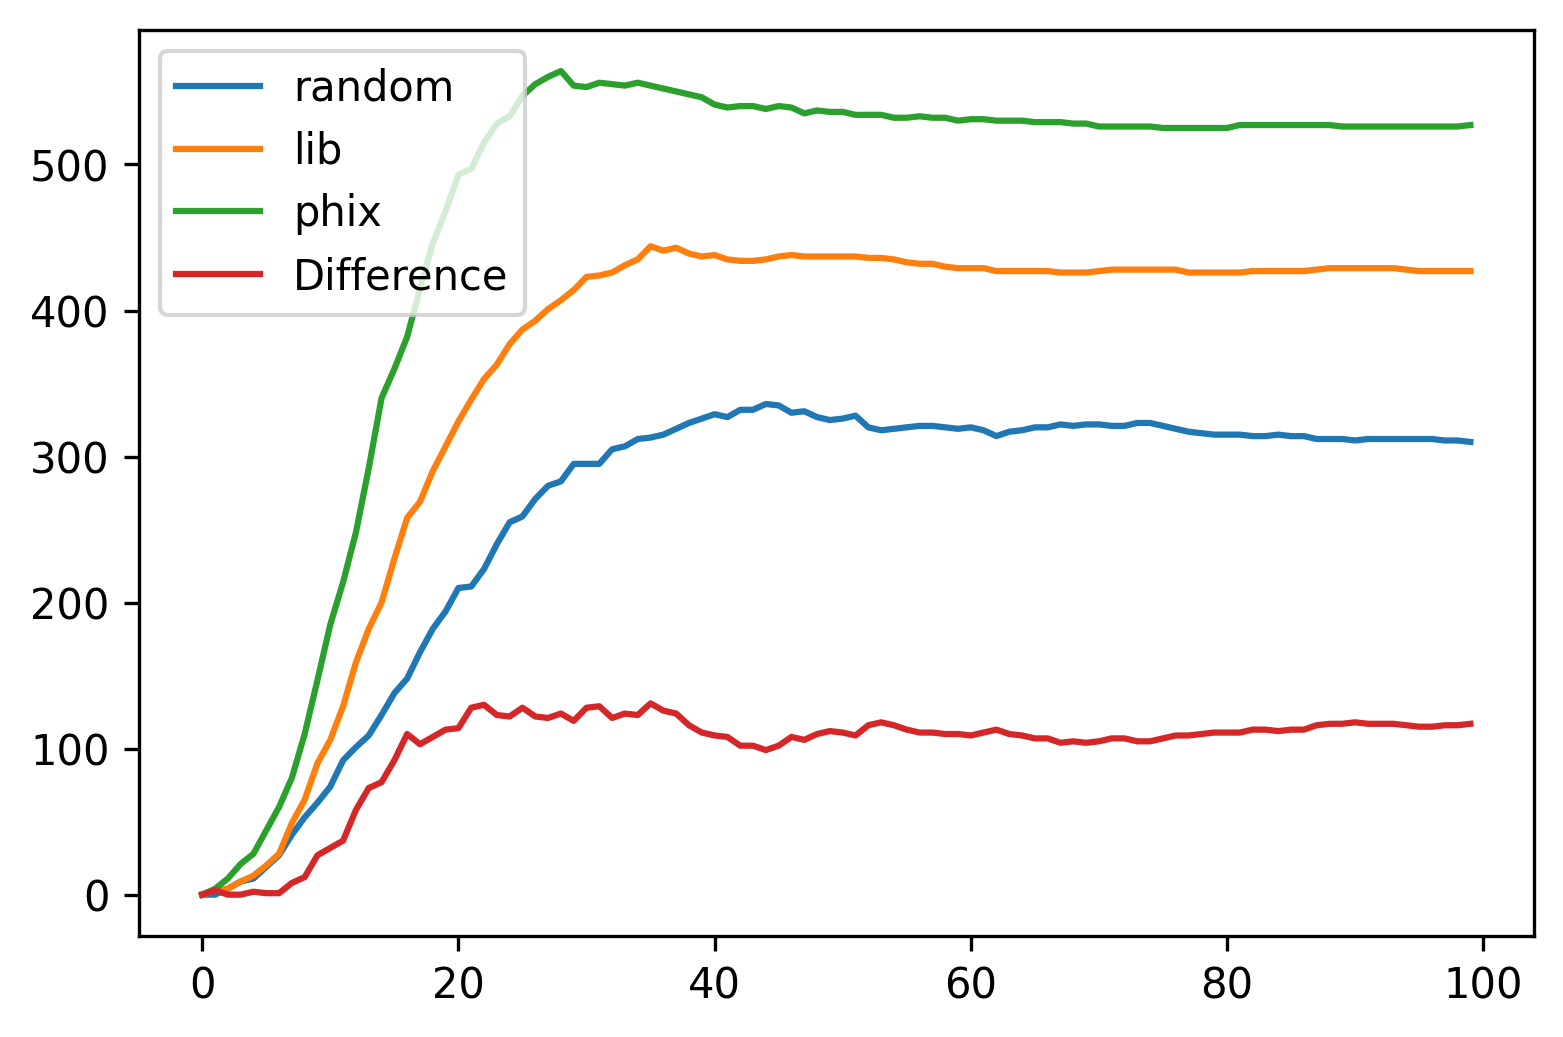

In [331]:
rd_set = []
for i in range(0, 1):
    rd = np.random.random((1300, 2))
    rd[:, 0] = rd[:, 0] * 512
    rd[:, 1] = rd[:, 1] * 256
    rd_set.append(rd)
# res_rd, idx_rd = count_nearest_pts(res, rd_set[0], 15)
# polished_fretPts_k = res[idx_rd[np.where(res_rd != inf)]]
# polished_rd_k = rd_set[0][np.where(res_rd != inf)]
# print(len(polished_rd_k))
rd_arr = []
arti_arr = []
phix_arr = []

peak_locations = combiened_peaks

res = model(np.array(peak_locations))
rd_res = model(np.array(rd_set[0]))
canvas_size = (1566, 3240)
ploting_res(canvas_size, rd_res, 3, save_path + "rd1.png")

save_path = "/Users/qinhanhou/Desktop/DeindlLab/0729Poly/0822_Combine2Channel/"
# ploting_res(canvas_size, res, 3, save_path + "transformed_res.png")
fastq = read_coord("/Users/qinhanhou/Desktop/DeindlLab/0729Poly/0817/coord_lib.csv")
phix = read_coord("/Users/qinhanhou/Desktop/DeindlLab/0729Poly/0817/coord_phix.csv")

for i in range(0, 100):
    res_rd, idx_rd = count_nearest_pts(rd_res, fastq, i)
    polished_fretPts_k = rd_res[idx_rd[np.where(res_rd != inf)]]
    polished_rd_k = fastq[np.where(res_rd != inf)]
    rd_arr.append(len(polished_rd_k))

for i in range(0, 100):
    res_final, idx_final = count_nearest_pts(res, fastq, i)
    polished_fretPts_final = res[idx_final[np.where(res_final != inf)]]
    polished_fastq_final = fastq[np.where(res_final != inf)]
    arti_arr.append(len(polished_fastq_final))

for i in range(0, 100):
    res_phix, idx_phix = count_nearest_pts(res, phix, i)
    polished_fretPts_phix = res[idx_phix[np.where(res_phix != inf)]]
    polished_fastq_phix = phix[np.where(res_phix != inf)]
    phix_arr.append(len(polished_fastq_phix))

plt.figure()
plt.plot(rd_arr, label='random')
plt.plot(arti_arr, label='lib')
plt.plot(phix_arr, label='phix')
plt.plot(np.array(arti_arr) - np.array(rd_arr), label='Difference')
plt.legend()
plt.show()
# ploting_res((x_range, y_range), polished_rd_k, 3, save_path + "polished_rd.png")
# ploting_res(
#     (x_range, y_range), polished_fretPts_k, 3, save_path + "polished_fretPts_rd.png"
# )
